# Проект по подготовке гипотез и анализу A\B-теста для крупного интернет-магазина. Цель - увеличение выручки

## Описание проекта:


Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Описание данных


**Данные для первой части**

Файл hypothesis.csv:

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Данные для второй части**

Файл orders.csv:

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл visitors.csv:

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузим библиотеки

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from datetime import datetime, timedelta
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import pylab 

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', None)

## Часть 1. Определим приоритетный порядок гипотез

Для этого используем два фреймворка - ICE и RICE:  

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

### Применим фреймворк ICE для приоритизации гипотез. 


In [ ]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
except:
    data = pd.read_csv('/datasets/hypothesis.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
data['ICE']=data['Impact'] * data['Confidence']/data['Efforts']

### Применим фреймворк RICE для приоритизации гипотез.


In [ ]:
data['RICE'] = data['Reach']*data['Impact']*data['Confidence']/data['Efforts']

Выведем общую таблицу. Приоритетные гипотезы по ICE и RICE подкрашены от темного к более светлому цвету.

In [ ]:
data.style.format({'ICE' : '{:.2f}', 'RICE' : '{:.2f}'}).background_gradient(subset=['ICE', 'RICE'], cmap='binary')\
.highlight_max(subset=['Reach'], color='black').highlight_min(subset=['Reach'], color='grey')

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20


Наиболее перспективные гипотезы по ICE: 8, 0, 7, 6.

Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6.

В перспективных гипотезах по RICE нет гипотезы 8, зато добавилась гипотеза 2. Расположение гипотез по их приоритету в двух фреймворках отличается. Чтобы понять, почему так произошло, достаточно взглянуть на баллы формулообразующих параметров исследуемых гипотез для фреймворков ICE и RICE.  

У гипотезы 8, которая на первом месте по ICE, высокие баллы параметров Impact (показывает, насколько сильно изменение повлияет на охваченных пользователей), 	Confidence (показывает, насколько мы уверены в оценках других параметров),	Efforts (показывает, во сколько компании обойдется проверка данной гипотезы). 

В рейтинге по RICE добавляется еще один параметр оценки гипотез - Reach (охват пользователей при проверке данной гипотезы). Он у гипотезы 7 равен максимальным 10 баллам при сравнительно высоких баллах и по другим параметрам, то есть охватит хотя бы половину пользователей компании, в то время как у гипотезы 8 балл по охвату пользователей равен единице, то есть минимальный.

Таким образом, приоритетными после "просеивания" гипотез по двум фреймворкам считаем гипотезы 7, 0, 6. Последовательность определили, исходя из рейтинга по RICE, поскольку он учитывает дополнительный важный параметр, демонстрирующий охват пользователей.

## Часть 2. Проведем анализ A/B-теста

Прочтём данные из файлов с результатами A/B-тестирования.

In [ ]:
try:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [ ]:
orders.isna().mean()

transactionId   0.00
visitorId       0.00
date            0.00
revenue         0.00
group           0.00
dtype: float64

In [ ]:
orders.duplicated().sum()

0

In [ ]:
orders['group'].value_counts(normalize=True)

B   0.53
A   0.47
Name: group, dtype: float64

Группы по размеру разные. Возможно, с пользователями в группе В работали более эффективно или причина просто в лучшей конверсии. 

In [ ]:
orders['date'].sort_values().unique()

array(['2019-08-01', '2019-08-02', '2019-08-03', '2019-08-04',
       '2019-08-05', '2019-08-06', '2019-08-07', '2019-08-08',
       '2019-08-09', '2019-08-10', '2019-08-11', '2019-08-12',
       '2019-08-13', '2019-08-14', '2019-08-15', '2019-08-16',
       '2019-08-17', '2019-08-18', '2019-08-19', '2019-08-20',
       '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-24',
       '2019-08-25', '2019-08-26', '2019-08-27', '2019-08-28',
       '2019-08-29', '2019-08-30', '2019-08-31'], dtype=object)

АВ-тестирование длилось один месяц - август 2019 года.

Проверим, есть ли у нас пересекающиеся пользователи, которые оказались в обеих группах сразу.

In [ ]:
orders.groupby('group').agg({'visitorId': 'nunique'}).sum()[0] - orders['visitorId'].nunique()

58

Да, таких 58 человек. Найдем их и исключим из теста для чистоты эксперимента.

In [ ]:
user_A = orders.query('group == "A"').agg({'visitorId': 'unique'})
user_B = orders.query('group == "B"').agg({'visitorId': 'unique'})
 
user_duplicates = list(set(user_A[0]).intersection(set(user_B[0])))

In [ ]:
orders = orders.query('visitorId != @user_duplicates').copy()

In [ ]:
orders.groupby('group').agg({'visitorId': 'nunique'}).sum()[0] - orders['visitorId'].nunique()

0

In [ ]:
orders['group'].value_counts(normalize=True)

B   0.54
A   0.46
Name: group, dtype: float64

Разница в группах немного увеличилась на 1 процентный пункт. Такое бывает. На причины возможной разницы мы указали, будем считать, что она небольшая и в пределах нормы.

In [ ]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [ ]:
try:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')
    
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [ ]:
visitors.isna().mean()

date       0.00
group      0.00
visitors   0.00
dtype: float64

In [ ]:
visitors.duplicated().sum()

0

In [ ]:
visitors['group'].value_counts(normalize=True)

B   0.50
A   0.50
Name: group, dtype: float64

Здесь группы распределены поровну.

In [ ]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [ ]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [ ]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Создадим массив уникальных пар значений дат и групп теста.

In [ ]:
datesGroups = orders[['date','group']].drop_duplicates()

Получим агрегированные кумулятивные по дням данные о заказах.

In [ ]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина.

In [ ]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Объединим кумулятивные данные в одной таблице cumulativeData и присвоим ее столбцам понятные названия:

    date — дата;
    group — группа A/B-теста (A или B);
    orders — кумулятивное количество заказов на указанную дату в указанной группе;
    buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
    revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
    visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [ ]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

### 1. Построим график кумулятивной выручки по группам. 

Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.

In [ ]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

Построим графики кумулятивной выручки по дням по группам.

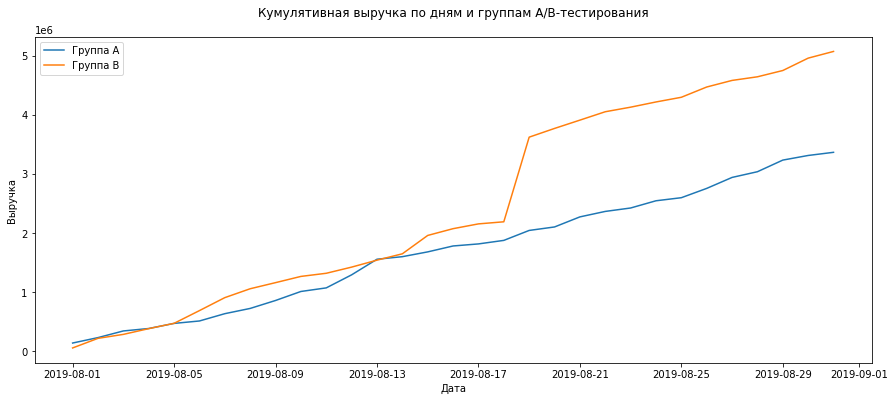

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по дням и группам A/B-тестирования', pad=20)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend(['Группа А', 'Группа B'])

plt.show()

Выручка увеличивается во время теста, и это радует. У группы А более равномерно, зато у группы В ее показатели выше. 
У группы В наблюдается всплеск выручки во второй половине месяца, что проводился тест. Возможно, число заказов действительно выросло, однако нельзя исключать появление очень дорогих заказов в выборке, которые могут исказить общую картину. 

### 2. Построим график кумулятивного среднего чека по группам.

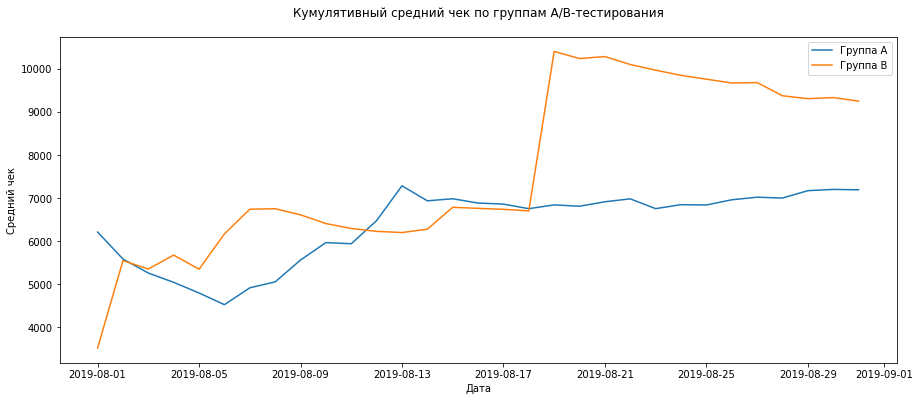

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Кумулятивный средний чек по группам A/B-тестирования', pad=20)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(['Группа А', 'Группа В'])

plt.show()

Кумулятивное значение среднего чека сильно колеблется в первой половине месяца. Во второй значение среднего чека у группы А стабилизируется в районе отметки в 7000 рублей, у группы В наблюдается резкий всплеск среднего чека до 10000 за четыре дня, потом значение плавно спадает до 9000 рублей и там стабилизируется. 

Требуется анализ выбросов, которые могут сильно искажать результат. 

### 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

Соберем данные в одну таблицу.

In [ ]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построим график.

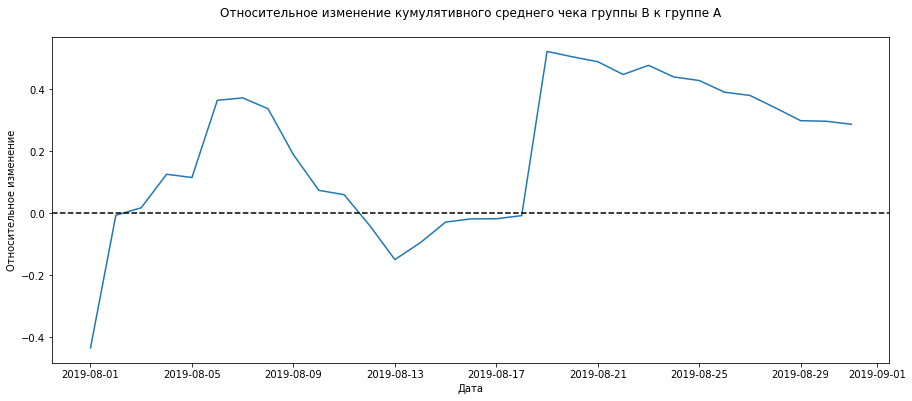

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(mergedCumulativeRevenue['date'],\
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', pad=20)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')

plt.show()

Различия по среднему чеку в группах резко скачут в те же дни, что и на предыдущем графике. Видимо, в эти дни и были совершены аномальные заказы.

### 4. Построим график кумулятивной конверсии по группам.

Посчитаем общую кумулятивную конверсию.

In [ ]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Разделим данные по группам.

In [ ]:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

Построим график и зададим масштаб осей.

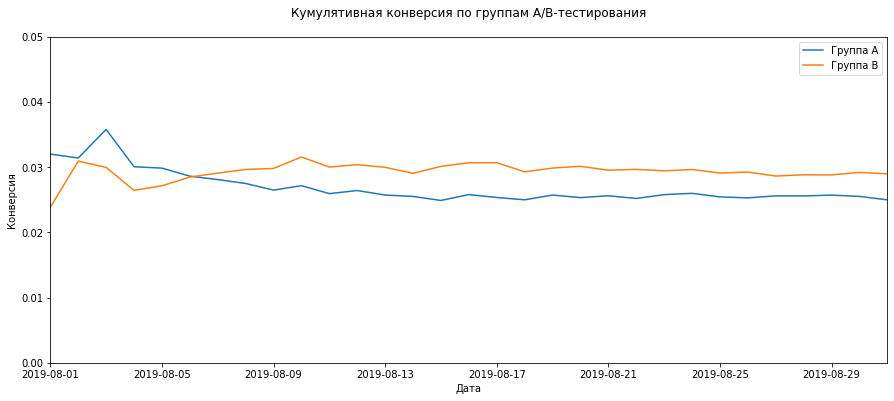

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])

plt.title('Кумулятивная конверсия по группам A/B-тестирования', pad=20)
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend(['Группа А', 'Группа В'])

plt.show()

Соревнуясь с  группой В в самом начале за одно значение, группа А на несколько дней опередила конкурента по кумулятивной конверсии, затем конверсия группы В вырвалась вперед и зафиксировалась. Конферсия группы А снизилась и тоже зафиксировалась. Изменение масштабов осей помогло определить, что конверсия установилась около своего среднего значения. Иначе мы бы могли сделать неверный вывод, будто колебания продолжаются. 

### 5. Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

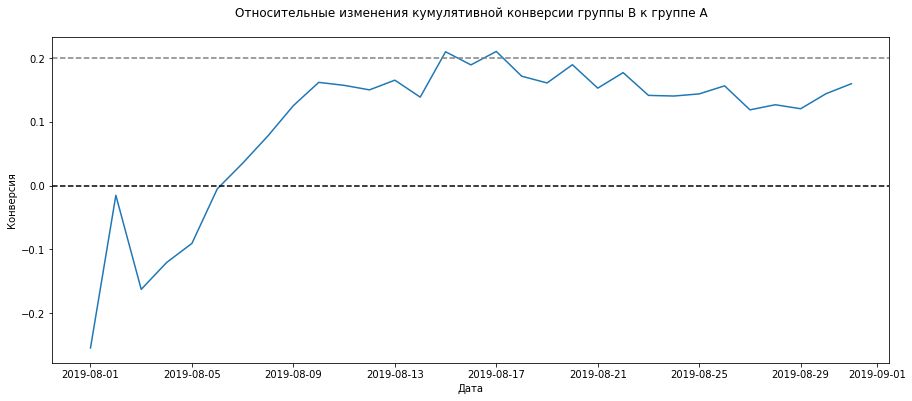

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B к группе A")

plt.title('Относительные изменения кумулятивной конверсии группы B к группе A', pad=20)
plt.xlabel('Дата')
plt.ylabel('Конверсия')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.show()

С первой недели группа В опередила группу А и росла по конверсии. Пик в 20% относительно группы А пришелся на середину теста, после этого конверсия группы В стала снижаться скачками до 10-15%. К концу исследуемого периода наблюдается небольшой рост. Необходимо проанализировать аномалии, они могут изменить картину.  

### 6. Построим точечный график количества заказов по пользователям.

Посчитаем количество заказов по пользователям.

In [ ]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

Построим график.

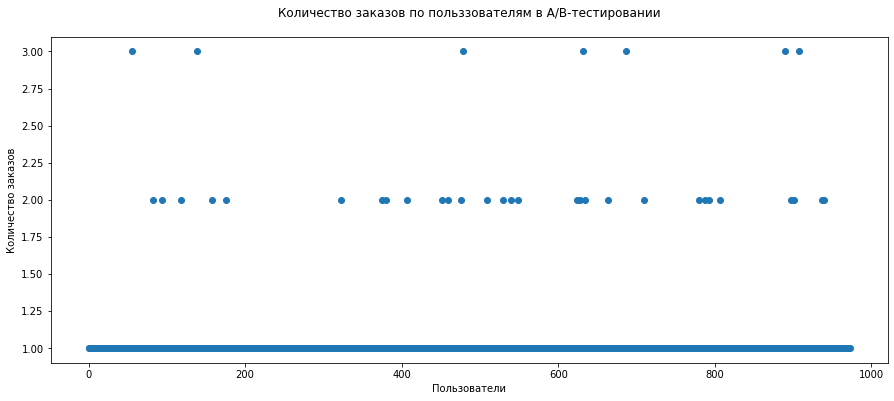

In [ ]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15, 6))
plt.scatter(x_values, ordersByUsers['orders']) 

plt.title('Количество заказов по польззователям в A/B-тестировании', pad=20)
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')

plt.show()

Большинство пользователей оставляли один заказ в рамках A\B-тестирования, есть пользователи с двумя и тремя заказами. Чтобы установить границу для определения аномальных пользователей, посчитаем выборочные перцентили количества заказов на одного пользователя.

### 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [ ]:
np.percentile(ordersByUsers['orders'], [95, 99]).astype(int).tolist()

[1, 2]

Не более 5% пользователей совершали больше одного заказа. Не более 1% пользователей - больше двух заказов.

Считаем разумным выбрать два заказа на одного пользователя за верхнюю границу числа заказов, а остальных пользователей считать аномальными.

### 8. Построим точечный график стоимостей заказов. 

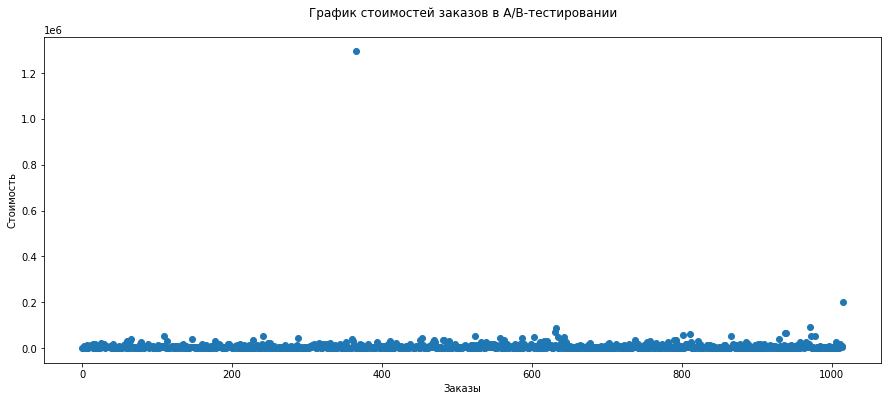

In [ ]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 6))
plt.scatter(x_values, orders['revenue']) 

plt.title('График стоимостей заказов в A/B-тестировании', pad=20)
plt.xlabel('Заказы')
plt.ylabel('Стоимость')

plt.show()

Львиная доля заказов на сумму - меньше 100 000 рублей. Аномальным выглядит заказ за 1 250 000 рублей. Для более корректной оценки следует расчитать перцентили.

### 9. Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [ ]:
np.percentile(orders['revenue'], [95, 99]).astype(int).tolist()

[26785, 53904]

Не более 5% заказов на сумму больше 27 000 рублей. Не более 1% заказов - больше 54 000 рублей.

Определим верхней границей заказ в 30 000 рублей, а остальные будем считать аномальными.

### 10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным, без удаления аномальных пользователей.

Для начала подготовим данные и объединим их в таблицу data. 
Зададим названия столбцов в датафрейме:

    date — дата;
    ordersPerDateA — количество заказов в выбранную дату в группе A;
    revenuePerDateA — суммарная выручка в выбранную дату в группе A;
    ordersPerDateB — количество заказов в выбранную дату в группе B;
    revenuePerDateB — суммарная выручка в выбранную дату в группе B;
    ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
    revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
    ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
    revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
    visitorsPerDateA — количество пользователей в выбранную дату в группе A;
    visitorsPerDateB — количество пользователей в выбранную дату в группе B;
    visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
    visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [ ]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(3)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

In [ ]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [ ]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA']\
                                                                           .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB']\
                                                                           .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Определим, какой из тестов мы будем проводить для выявления статистической значимости различий. Напомним, T-test проводим при нормальном распределении среднего, тест Манна-Уитни - при ненормальном распределении среднего. Осталось разобраться, какой именно тип распределения среднего в наших переменных. Для этого посмотрим на него через qq-график.

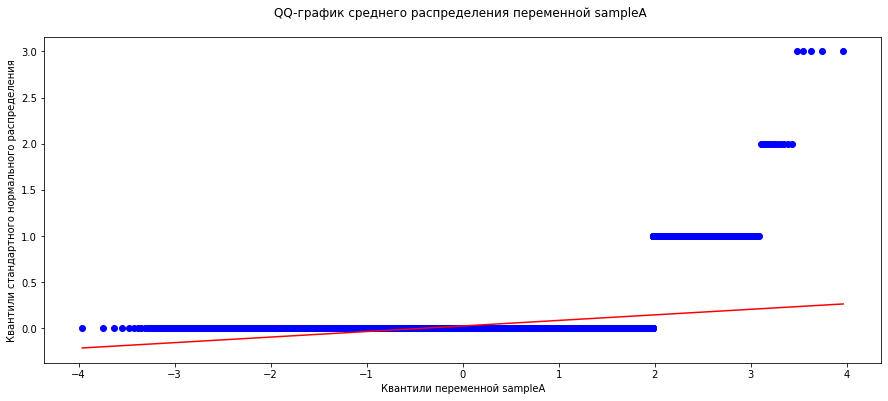

In [ ]:
plt.figure(figsize=(15, 6))

st.probplot(sampleA, dist="norm", plot=pylab)

plt.title('QQ-график среднего распределения переменной sampleA ', pad=20)
plt.xlabel('Квантили переменной sampleA')
plt.ylabel('Квантили стандартного нормального распределения')
pylab.show()

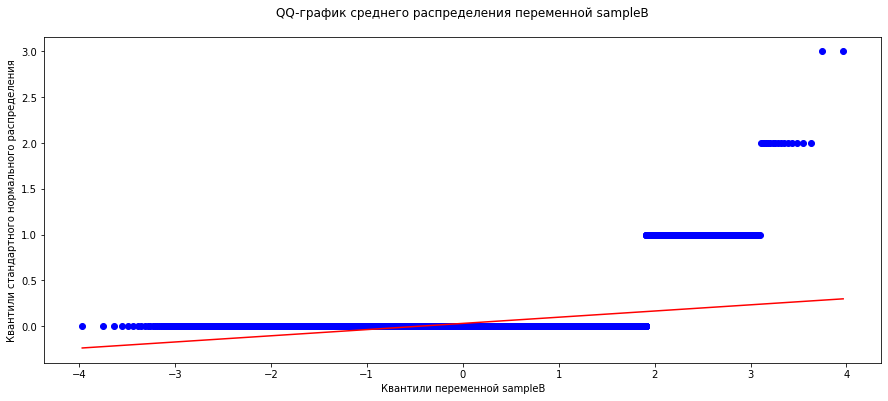

In [ ]:
plt.figure(figsize=(15, 6))

st.probplot(sampleB, dist="norm", plot=pylab)

plt.title('QQ-график среднего распределения переменной sampleB', pad=20)
plt.xlabel('Квантили переменной sampleB')
plt.ylabel('Квантили стандартного нормального распределения')
pylab.show()

Если бы синие точки повторяли красную линию, которая бы шла вверх под углом, близким к 45 градусам, данные в переменных были бы распределены нормально. Мы же имеем дело с ненормально распределенными данными. Следовательно, для статистического теста будем использовать тест Манна-Уитни.

Проведем тест. Сформулируем гипотезы. Нулевая, по традиции, консервативная. alpha установим на уровне 0,05 - это общепринятое пороговое значение.

    H_0: Среднее количество заказов группы А = среднему количеству заказов группы В
    Н_а: Среднее количество заказов группы А ≠ среднему количеству заказов группы В
   
    alpha = 0.05

In [ ]:
results = st.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]

alpha = 0.05 

print('p-value =', "{0:.3f}".format(results), 'при alpha = 0.05 ')

if results < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

print()
print('Изменение в конверсии между двумя группами =',\
      "{0:.1f}".format((sampleB.mean() / sampleA.mean() - 1)*100), '%')

p-value = 0.011 при alpha = 0.05 
Отвергаем нулевую гипотезу

Изменение в конверсии между двумя группами = 16.0 %


Нулевая гипотеза отвергнута. Судя по неочищенным данным, в среднем количестве заказов двух групп есть статистически значимые различия. Относительный прирост среднего группы Б к конверсии группы А равен 16%.

### 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Формулируем гипотезы:

    H_0: Средний чек заказа из группы А = среднему чеку заказа из группы В
    Н_а: Средний чек заказа из группы А ≠ среднему чеку заказа из группы В
   
    alpha = 0.05

In [ ]:
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative="two-sided")[1]

alpha = 0.05 

print('p-value =', "{0:.3f}".format(results), 'при alpha = 0.05')

if results < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

print()
print('Изменение различий в среднем чеке между двумя группами =',\
      "{0:.1f}".format((orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)*100), '%')

p-value = 0.829 при alpha = 0.05
Не получилось отвергнуть нулевую гипотезу

Изменение различий в среднем чеке между двумя группами = 28.7 %


P-value значительно больше 0,05, из чего следует, что статистически значимых отличий в среднем чеке между группами нет. Однако относительное различие чека между сегментами составляет солидные почти 29%.
Избавимся от аномалий.

### 12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Подготовим данные. 
Сделаем срезы пользователей с числом заказов больше 3-х — usersWithManyOrders и пользователей, совершивших заказы дороже 30 000 рублей — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers, удалим дубликаты, отсортируем по возрастанию.

Напомним, заказы больше двух и дороже 30 000 рублей мы решили считать аномальными.

In [ ]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

Зададим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах без аномальных пользователей.

In [ ]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders', ),], axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders',),], axis=0,) 

Формулируем гипотезы:

    H_0: Среднее количество заказов группы А (без аномалий) = среднему количеству заказов группы В (без аномалий)
    Н_а: Среднее количество заказов группы А (без аномалий) ≠ среднему количеству заказов группы В (без аномалий)
   
    alpha = 0.05

In [ ]:
results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]

alpha = 0.05 

print('p-value =', "{0:.3f}".format(results), 'при alpha = 0.05 ')

if results < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

print()
print('Изменение результатов по конверсии между двумя группами с "очищенными" данными =',\
      "{0:.1f}".format((sampleBFiltered.mean()/sampleAFiltered.mean()-1)*100), '%')

p-value = 0.010 при alpha = 0.05 
Отвергаем нулевую гипотезу

Изменение результатов по конверсии между двумя группами с "очищенными" данными = 18.7 %


Нулевая гипотеза отвергнута и с оцищенными данными тоже. Относительный прирост среднего группы Б к конверсии группы А равен 18,7%, даже почти на три процента  больше, чем в ситуации с "сырыми" данными.

### 13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами после удаления аномальных пользователей. 

Формулируем гипотезы:

    H_0: Средний чек заказа из группы А (без аномалий) = среднему чеку заказа из группы В (без аномалий)
    Н_а: Средний чек заказа из группы А (без аномалий) ≠ среднему чеку заказа из группы В (без аномалий)
   
    alpha = 0.05

In [ ]:
results = st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
                    orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'], alternative="two-sided")[1]

alpha = 0.05 

print('p-value =', "{0:.3f}".format(results), 'при alpha = 0.05 ')

if results < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

print()
print('Изменение различий в среднем чеке между двумя группами (без аномалий) =',\
      "{0:.1f}".format((orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()\
        / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean() - 1)*100), '%')

p-value = 0.741 при alpha = 0.05 
Не получилось отвергнуть нулевую гипотезу

Изменение различий в среднем чеке между двумя группами (без аномалий) = -2.7 %


P-value высокий, следовательно, статистически значимых отличий в среднем чеке между группами точно нет. Относительное различие чека между сегментами при этом незначительное, -2,7%.

Итого:
- Cтатистическая значимость различий в конверсии между группами по «сырым» данным = 16%, p-value = 0.011, количество заказов отличается.;
- Cтатистическая значимость различий в конверсии между группами по «очищенным» данным = 28.7%, p-value = 0.829, количество заказов отличается.
- Cтатистическая значимость различий по среднему чеку между группами по «сырым» данным = 18.7%, p-value = 0.010, средний чек не отличается;
- Cтатистическая значимость различий по среднему чеку между группами по «очищенным» данным = -2.7%, p-value = 0.741, средний чек не отличается.

Общие результаты гипотез не изменились. Сделаем выводы.

### 13. Выводы


1. Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;

2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A как минимум на 10%, и в данный момент показатель растет:


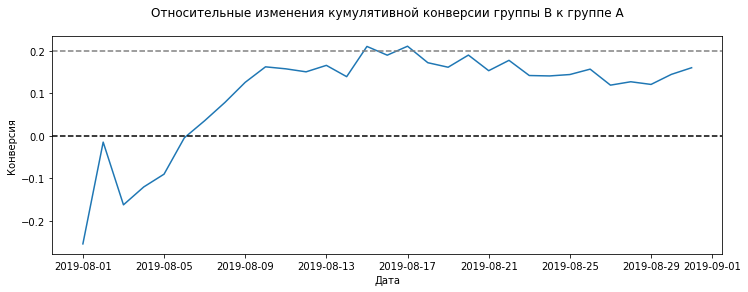

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B к группе A")

plt.title('Относительные изменения кумулятивной конверсии группы B к группе A', pad=20)
plt.xlabel('Дата')
plt.ylabel('Конверсия')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.show()

4. График различия среднего чека говорит о том, что результаты группы B улучшились на 50%, потом снизились до 30%, в данный момент наблюдается стабилизация:

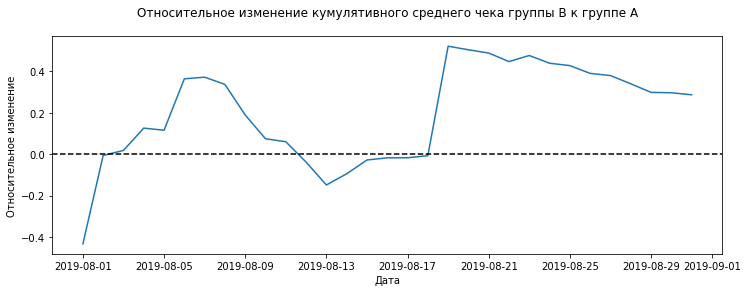

In [ ]:
plt.figure(figsize=(12, 4))

plt.plot(mergedCumulativeRevenue['date'],\
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', pad=20)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')

plt.show()


Считаем, тест следует остановить и признать его успешным. Исследование длится месяц - достаточный срок, чтобы собрать данные. Группа B по графикам выигрывает. Даже если статистически средний чек не изменился, конверсия выросла.